## Setup Multi-Modal model

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.3 MB/s eta 0:00:00


In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import re
import os
import matplotlib.pyplot as plt
import random
import numpy as np

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cpu = torch.device("cpu")

device

device(type='cuda')

In [10]:
class TextEncoder(nn.Module):
  def __init__(self, dim, vocab_size, max_seq_len):
    super(TextEncoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, dim)

    self.positional_embedding = nn.Parameter(torch.zeros(1, max_seq_len, dim))
  
  def forward(self, x):

    # x should be batches of tokens

    x = self.embedding(x)

    x = x + self.positional_embedding[:,:x.shape[1],:]

    return x

sample_model = TextEncoder(64, 10, 5)

sample_tokens = torch.tensor([[1,2,3,4]])
sample_model(sample_tokens).shape

torch.Size([1, 4, 64])

In [11]:
class ImageEncoder(nn.Module):
  def __init__(self, dim, input_size, patch_size):
    super(ImageEncoder, self).__init__()

    self.dim = dim

    scale = dim ** -0.5
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=dim, kernel_size=patch_size, stride=patch_size, bias=False)
    self.positional_embedding = nn.Parameter(scale * torch.randn((input_size // patch_size) ** 2, dim))

  def forward(self, x):

    # x.shape:
    # [ batch_size, num_images, rgb, width, height ]

    batch_size, num_images, rgb, width, height = x.shape
    
    x = x.reshape(batch_size * num_images, rgb, width, height) 

    # x.shape:
    # [ batch_size * num_images, rgb, width, height ]

    x = self.conv1(x)

    batch_image_prod, dim, grid_w, grid_h = x.shape

    x = x.reshape(batch_size, num_images, dim, grid_w, grid_h)

    # x.shape:
    # [ batch_size, num_images, dim, grid_size, grid_size ]
    
    x = x.reshape(batch_size, num_images, self.dim, -1)

    # x.shape:
    # [ batch_size, num_images, dim, grid_size ** 2 ]

    x = x.permute(0, 1, 3, 2)

    # x.shape:
    # [ batch_size, num_images, grid_size ** 2, dim ]

    # the position of each image in the web page is irrelevant, however
    # this allows the model to encode the position of each patch 
    # on each image 

    x = x + self.positional_embedding

    batch_size, num_images, image_grid, dim = x.shape

    x = x.reshape(batch_size, num_images * image_grid, dim)

    return x


sample_model = ImageEncoder(64, 224, 32)

sample_input = torch.zeros(8, 4, 3, 224, 224)
sample_model(sample_input).shape

torch.Size([8, 196, 64])

In [26]:
class WebPageFeatureExtractor(nn.Module):
  def __init__(self, dim, num_heads, num_layers, hidden_dim, dropout, max_text_seq_len, image_size, vocab_size):
    super(WebPageFeatureExtractor, self).__init__()

    self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim, num_heads, hidden_dim, dropout),
            num_layers
    )
        
    scale = dim ** -0.5
    self.class_embedding = nn.Parameter(scale * torch.randn(dim))

    self.img_encoder = ImageEncoder(dim, image_size, 32)
    self.txt_encoder = TextEncoder(dim, vocab_size, max_text_seq_len)

  def forward(self, img, txt):

    # img:
    # a tensor of any amount of images
    # img.shape:
    # [ batch_size, num_images, rgb, image_size, image_size]

    img_embeddings = self.img_encoder(img)

    # img_embeddings.shape:
    # [ batch_size, grid_size ** 2, dim ]


    # txt:
    # a tensor of tokens
    # txt.shape
    # [ batch_size, seq_len ]

    txt_embeddings = self.txt_encoder(txt)

    # txt_embeddings.shape
    # [ batch_size, seq_len, dim ]


    batch_size = img_embeddings.shape[0]
    class_embeddings = self.class_embedding + torch.zeros(batch_size, 1, self.class_embedding.shape[-1]).to(self.class_embedding.device)
    
    x = torch.cat(
        [ class_embeddings, img_embeddings, txt_embeddings ],
        dim = 1
    )

    x = self.transformer(x)

    x = x[:, 0, :]

    return x

model = WebPageFeatureExtractor(
    dim = 512,
    num_heads = 8,
    num_layers = 12,
    hidden_dim = 1024, 
    dropout = 0.2, 
    max_text_seq_len = 256,
    image_size = 224,
    vocab_size = 30522
).to(device)

sample_text = torch.tensor([[1,2,3,4,5,6,7,8], [9,10,11,12,13,14,15,16]]).to(device)
sample_images = torch.zeros(2, 4, 3, 224, 224).to(device)



print(f"model uses {sum(p.numel() for p in model.parameters()) / 1000000} million parameters")

model uses 42.590208 million parameters


In [27]:
model(sample_images, sample_text)

tensor([[-0.0899, -1.1974,  0.4384,  ...,  0.6403,  1.6874,  1.6026],
        [ 0.3303, -0.9357,  0.6114,  ...,  0.5593,  1.0078,  1.1408]],
       device='cuda:0', grad_fn=<SliceBackward0>)

## Data

In [ ]:
IMAGES_PER_BATCH = 1
WORDS_PER_BATCH = 256

DATA_DIR = "/Users/cameronryan/Desktop/Balene_DS_V1"

In [ ]:
# this function is to decide whether or not a web page
def validate_datapoint(path):
    try:
        with open(os.path.join(DATA_DIR,"/pages",path), "r") as f:
            text = f.read()

        split_data = text.split('IMAGES_DONE')

        image_paths, text = split_data[0], split_data[1]

        image_paths = image_paths.split('\n')
        image_paths = [path for path in image_paths if path != '']

        if len(image_paths) < IMAGES_PER_BATCH * 2:
            return False

        if len(text.split(' ')) < WORDS_PER_BATCH * 2:
            return False
    except: 
        return False

    return True

In [28]:
image_transform = transforms.Compose([
    transforms.ToTensor(),                                                       # Convert the image to a tensor
    transforms.Resize((224, 224), antialias=True),                               # Resize the image to (224, 224)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define the dataset class.
class WebContentDataset(Dataset):

    def __init__(self, paths):
        self.paths = paths

        self.max_images = IMAGES_PER_BATCH
        self.max_tokens = WORDS_PER_BATCH

    def __len__(self):
          return len(self.paths)

    def __getitem__(self, idx):

      with open(os.path.join("data/pages",self.paths[idx]), "r") as f:
        text = f.read()

      split_data = text.split('IMAGES_DONE')

      image_paths, text = split_data[0], split_data[1]


      images_tensor = torch.ones(1, 3, 224, 224)

      image_paths = image_paths.split('\n')
      image_paths = [path for path in image_paths if path != '']

      random.shuffle(image_paths)
      image_paths = image_paths[:self.max_images * 2]

      for path in image_paths:
        image_tensor = image_transform(Image.open(path)).unsqueeze(0)
        images_tensor = torch.cat([images_tensor, image_tensor], dim=0)
      
      images_tensor = images_tensor[1:, :, :]


      tokens = tokenizer.encode(text, return_tensors='pt').squeeze()


      num_tokens = tokens.shape[0]
      num_images = images_tensor.shape[0]

      assert num_tokens >= self.max_tokens * 2
      assert num_images >= self.max_images * 2

      
      img_seq_1 = images_tensor[:self.max_images, :, :, :]
      img_seq_2 = images_tensor[self.max_images : self.max_images * 2, :, :, :]

      tok_seq_1 = tokens[:self.max_tokens]
      tok_seq_2 = tokens[self.max_tokens : self.max_tokens * 2]
      

      return (img_seq_1, tok_seq_1), (img_seq_2, tok_seq_2)

file_paths = os.listdir("data/pages")
file_paths = [path for path in file_paths if validate_datapoint(path)]
ds = WebContentDataset(file_paths)
len(ds)#, ds[0]

948

In [29]:
batch_size = 32

dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

In [30]:
criterion = torch.nn.CrossEntropyLoss()

parameters = list(model.parameters()) 
optim = torch.optim.Adam(parameters, lr = 0.00001)

Inference the model, using it for search

In [31]:
def cosine_similarity(vector1, vector2):

    # Normalize the tensors to unit length
    tensor1 = F.normalize(vector1, dim=0)
    tensor2 = F.normalize(vector2, dim=0)

    # Calculate the cosine similarity between the two tensors
    similarity = F.cosine_similarity(tensor1, tensor2, dim=0)

    return similarity.item()

In [50]:
def open_data(path : str):

  with open(path, "r") as f:
    text = f.read()

  split_data = text.split('IMAGES_DONE')

  image_paths, text = split_data[0], split_data[1]
  

  images_tensor = torch.ones(1, 3, 224, 224)

  image_paths = image_paths.split('\n')
  
  
  random.shuffle(image_paths)
  image_paths = image_paths[:2]

  image_paths = filter(lambda x : x != '', image_paths)
  for path in image_paths:
    image_tensor = image_transform(Image.open(path)).unsqueeze(0)
    images_tensor = torch.cat([images_tensor, image_tensor], dim=0)
  
  images_tensor = images_tensor[1:, :, :]

  images_tensor = images_tensor.unsqueeze(0)
  #images_tensor = shuffle_tensor(images_tensor, 0).unsqueeze(0)[:,:2,:,:,:]

  tokens = tokenizer.encode(text, return_tensors='pt')[:,:256]

  return images_tensor, tokens

def encode_data(path : str) -> torch.tensor:

  images, tokens = open_data(path)

  images, tokens = images.to(device), tokens.to(device)

  #print(images, tokens)
  #model.eval()

  with torch.no_grad():
    vec = model(images, tokens)

  return vec


def get_search_vecs():

  search_dict = dict()

  for path in search_paths:
    vec = encode_data(path)

    page_name = path.split('/')[-1]
    search_dict[page_name] = vec
  
  return search_dict

def get_search_scores():
  vec_dict = get_search_vecs()

  query_vec = vec_dict["orion_nebula.txt"].squeeze()

  for key in vec_dict.keys():
    key_vec = vec_dict[key].squeeze()

    similarity = cosine_similarity(query_vec, key_vec)

    vec_dict[key] = similarity
  
  return vec_dict

def create_cosimilarity_matrix(vec_dict):

  keys = vec_dict.keys()

  output = torch.zeros(len(keys), len(keys))

  for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
      similarity = cosine_similarity(vec_dict[key1].squeeze(), vec_dict[key2].squeeze())
      output[i][j] = similarity
  
  return output



search_paths = [
    "banana.txt",
    "dog.txt",
    "flower.txt",
    "orion_nebula.txt",
    "the_milky_way.txt",
    "tree.txt",
    "weather.txt",
    "jungle.txt",
    "the_sun.txt"
]
search_paths = [f"sample_data/pages/{page}" for page in search_paths]
search_paths.append("sample_data/pages/query.txt")
print(search_paths)
get_search_scores()

['sample_data/pages/banana.txt', 'sample_data/pages/dog.txt', 'sample_data/pages/flower.txt', 'sample_data/pages/orion_nebula.txt', 'sample_data/pages/the_milky_way.txt', 'sample_data/pages/tree.txt', 'sample_data/pages/weather.txt', 'sample_data/pages/jungle.txt', 'sample_data/pages/the_sun.txt', 'sample_data/pages/query.txt']


{'banana.txt': 0.8266123533248901,
 'dog.txt': 0.8085715174674988,
 'flower.txt': 0.8722561597824097,
 'orion_nebula.txt': 0.8508518934249878,
 'the_milky_way.txt': 0.8369104266166687,
 'tree.txt': 0.810700535774231,
 'weather.txt': 0.8831431269645691,
 'jungle.txt': 0.8364739418029785,
 'the_sun.txt': 0.8495548367500305,
 'query.txt': 1.0}

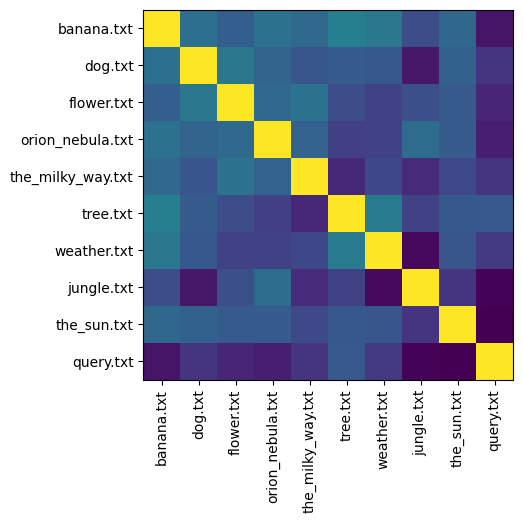

In [33]:
vec_dict = get_search_vecs()
mat = create_cosimilarity_matrix(vec_dict)
keys = list(vec_dict.keys())
tick_marks = np.arange(len(keys))
plt.xticks(tick_marks, keys, rotation = 90)
plt.yticks(tick_marks, keys)
plt.imshow(mat)

In [34]:
!pip install neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.6 MB/s eta 0:00:00


In [35]:
import neptune

run = neptune.init_run(
    project="cjryanwashere/Search-Engine",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ODc4MDgwNS0wYzEwLTQ4MWEtOTJlOS0wODAxY2JmNmIzYmEifQ==",
)  # your credentials


<ipython-input-35-2cc3f6c79269>:3: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/cjryanwashere/Search-Engine/e/SEARCH-7


In [43]:
def write_cosimilarity_matrix():

  vec_dict = get_search_vecs()

  mat = create_cosimilarity_matrix(vec_dict)

  keys = list(vec_dict.keys())
  tick_marks = np.arange(len(keys))

  fig, ax = plt.subplots()
  ax.imshow(mat)
  plt.close()
  ax.set_xticks(tick_marks, keys, rotation=90)
  ax.set_yticks(tick_marks, keys)

  run["figures/similarity"].append(fig)

write_cosimilarity_matrix()

In [44]:
def write_search_scores():
  scores = get_search_scores()

  for key in scores.keys():
    run[f"cosine_similarity/{key}"].append(scores[key])

write_search_scores()

In [52]:
for epoch in range(100):
  print(f"\n epoch {epoch}")
  model.train()
  for i, batch in enumerate(dl):

    seq_1, seq_2 = batch
    (img_1, tok_1), (img_2, tok_2) = seq_1, seq_2
    img_1, tok_1, img_2, tok_2 = img_1.to(device), tok_1.to(device), img_2.to(device), tok_2.to(device)

    out_1, out_2 = model(img_1, tok_1), model(img_2, tok_2)
    #out_1, out_2 = model(*seq_1), model(*seq_2)

    similarity_matrix = out_1 @ out_2.T
    label = torch.eye(similarity_matrix.shape[0]).to(device)

    loss = criterion(similarity_matrix, label)
    run["train/loss"].append(loss.item())

    loss.backward()

    optim.step()

    optim.zero_grad()
    
    print(".",end='')



 epoch 0
writing search result scores
..............................
 epoch 1
..............................
 epoch 2
..............................
 epoch 3
..............................
 epoch 4
..............................
 epoch 5
writing search result scores
..............................
 epoch 6
..............................
 epoch 7
..............................
 epoch 8
..............................
 epoch 9
............................

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6591cbb520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


..
 epoch 10
writing search result scores
..............................
 epoch 11
..............................
 epoch 12
..............................
 epoch 13
..............................
 epoch 14
..............................
 epoch 15
writing search result scores
..............................
 epoch 16
..............................
 epoch 17
..............................
 epoch 18
..............................
 epoch 19
..............................
 epoch 20
writing search result scores
...................

KeyboardInterrupt: ignored

In [25]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cjryanwashere/Search-Engine/e/SEARCH-6/metadata
